In [1]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from superpoint.settings import DATA_PATH, EXPER_PATH
from superpoint.radial_distortion.radial_dist_funct import distort,undistort
from superpoint.generate_coco_patches import _preprocess
from superpoint.models.homographies import sample_homography, invert_homography, flat2mat
#from superpoint.dataset.utils.pipeline import ratio_preserving_resize

from utils import plot_imgs

%matplotlib inline
%load_ext autoreload
%autoreload 2
tf.logging.set_verbosity(0)

In [390]:
image_name = 'COCO_train2014_000000000071.jpg' #'COCO_train2014_000000130745.jpg' #'COCO_train2014_000000519723.jpg'  # #'COCO_train2014_000000114404.jpg' #'COCO_train2014_000000151493.jpg' #
model_name = 'magic-point_synth'
base_path = Path(DATA_PATH, 'COCO/train2014/')
filename = Path(base_path, image_name)
#checkpoint = Path(EXPER_PATH, model_name) 
#print(filename)

In [412]:
config = {
    'homographies':{
        'translation': True,
        'rotation': True,
        'scaling': True,
        'perspective': True,
        'scaling_amplitude': 0.1,
        'perspective_amplitude_x': 0.05,
        'perspective_amplitude_y': 0.05,
        'patch_ratio': 0.8,
        'max_angle': 3.14
    },
    'distortion':{
        'enable': True 
    },
    'preprocessing':{
        'resize': [240, 320]
    }
}

In [413]:
def _scale_preserving_resize(image):
    target_size = tf.convert_to_tensor(config['preprocessing']['resize'])
    scales = tf.to_float(tf.divide(target_size, tf.shape(image)[:2]))
    new_size = tf.to_float(tf.shape(image)[:2]) * tf.reduce_max(scales)
    image = tf.image.resize_images(image, tf.to_int32(new_size),
                                   method=tf.image.ResizeMethod.BILINEAR)
    return tf.image.resize_image_with_crop_or_pad(image, target_size[0],
                                                  target_size[1])


def _preprocess(image):
    image = tf.image.rgb_to_grayscale(image)
    if config['preprocessing']['resize']:
        image = _scale_preserving_resize(image)
    return image


def _preprocess2(image):
    #tf.Tensor.set_shape(image, [None, None, 1])
    #image = tf.image.rgb_to_grayscale(image)
            #if config['preprocessing']['resize']:
               # image = ratio_preserving_resize(image, **config['preprocessing'])
    return tf.to_float(image)


In [414]:
image = tf.image.decode_jpeg(tf.read_file(str(filename)), channels=3)
image = _preprocess(image)
shape = tf.shape(image)[:2]

In [415]:
 # Warp the image
H = sample_homography(tf.shape(image)[:2], **config['homographies'])
warped_image = tf.contrib.image.transform(image, H, interpolation="BILINEAR")
distortion = config['distortion']['enable']
#apply distortion:
if(distortion):
    row_c = tf.random_uniform(shape=[], minval=0, maxval=tf.cast(240, tf.float32), dtype=tf.float32) #tf.constant(120.)
    col_c = tf.random_uniform(shape=[], minval=0, maxval=tf.cast(320, tf.float32), dtype=tf.float32) #tf.constant(160.) 
    lambda_ = 0.000009
    warped_image = tf.reshape(warped_image, [240,320,1])
    warped_image = distort(warped_image[tf.newaxis,...], lambda_, (row_c, col_c))
    sh = tf.shape(warped_image)
    warped_image = tf.reshape(warped_image, sh[1:3])

H = invert_homography(H)
H = flat2mat(H)[0, :, :]

#H = tf.reshape(H, [-1, 9])
#H = (H / H[:, 8:9])[:, :8]
#H = (invert_homography(tf.cast(H,tf.float32)))

(240, 320, 1)
(109.64184, 196.72153)


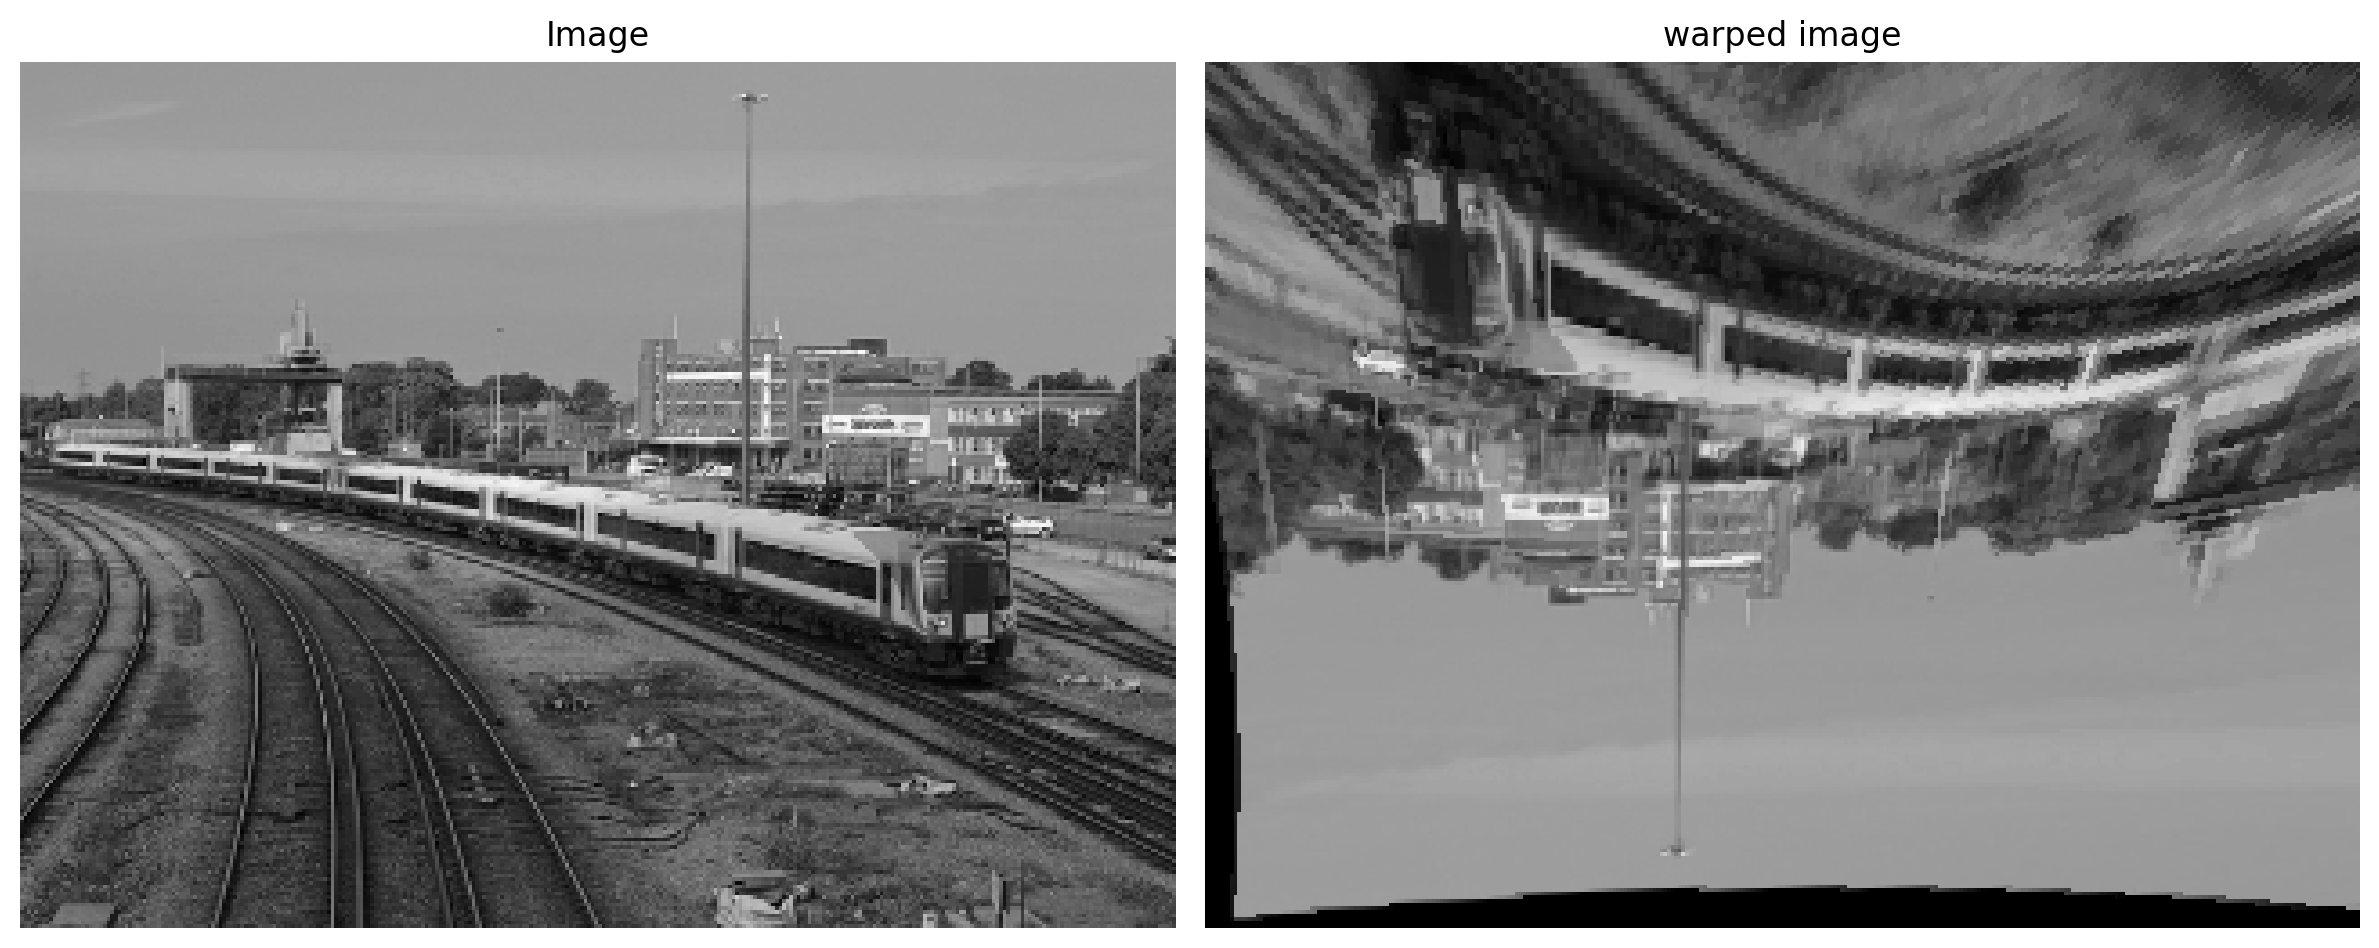

In [416]:
with tf.Session() as sess:
    im, warped_im, homography, r, c=  sess.run([image, warped_image, H, row_c, col_c])
    #distortion_center = (r_c, c_c)
    plot_imgs([np.reshape(im, [240, 320]) / 255, np.reshape(warped_im, [240, 320]) / 255], titles=['Image','warped image'], dpi=200, cmap='gray')
    print(im.shape)
    #im = np.reshape(im, [240, 320])
    #print(distortion_center)
    cv2.imwrite(str(Path(DATA_PATH, "1.jpg")), im)
    cv2.imwrite(str(Path(DATA_PATH, "2.jpg")), warped_im)
    np.savetxt(Path(DATA_PATH, "H_1_2"), homography, '%.5g')
    if(distortion):
        factors = np.array([r, c, lambda_])
        print((r, c))
        np.savetxt(Path(DATA_PATH, "dist_factors"), factors, fmt='%.5g')

In [6]:
image = cv2.imread("1.jpg")
#tf.Tensor.set_shape(image, [None, None, 3])
image = tf.image.rgb_to_grayscale(image)
print(image)
warped_image = cv2.imread("2.jpg")
#tf.Tensor.set_shape(warped_image, [None, None, 3])
warped_image = tf.image.rgb_to_grayscale(warped_image)
print(warped_image.shape)

H = np.loadtxt("H_1_2")
facts = np.loadtxt("dist_factors")
l = facts[2]
cen = (facts[0], facts[1])
H = tf.reshape(H, [-1, 9])
H = (H / H[:, 8:9])[:, :8]
H = (invert_homography(tf.cast(H,tf.float32)))


im = tf.cast(tf.convert_to_tensor(image), tf.float32)
warped_image = tf.cast(tf.convert_to_tensor(warped_image), tf.float32)

#im = tf.reshape(im, [240, 320,1])
warped_image_test_2 = tf.contrib.image.transform(im, H, interpolation="BILINEAR")
warped_image_test_2 = tf.reshape(warped_image_test_2, [240, 320,1])
warped_image_test_2 = distort(warped_image_test_2[tf.newaxis,...], l, cen)

warped_image_test_2 = tf.reshape(warped_image_test_2, warped_image.shape)
print(warped_image_test_2.shape) 
print(cen)


Tensor("rgb_to_grayscale_4:0", shape=(240, 320, 1), dtype=uint8)
(240, 320, 1)
(240, 320, 1)
(6.6611, 185.83)


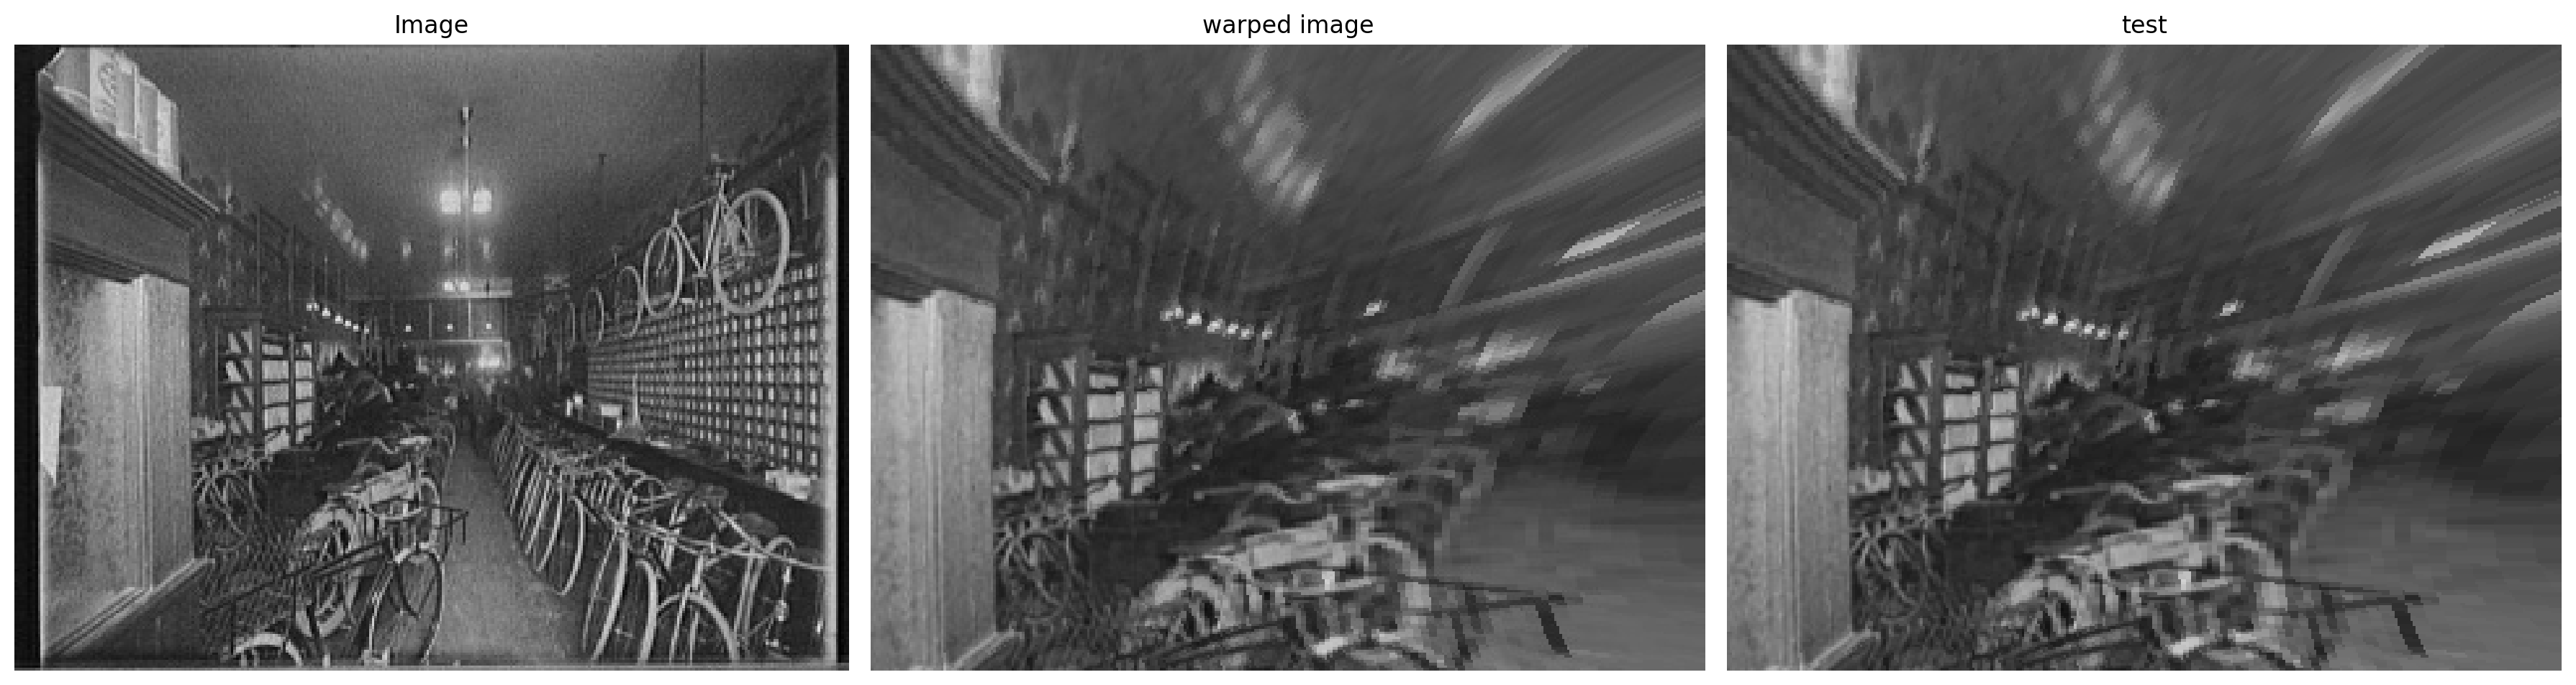

In [7]:
with tf.Session() as sess:
    im, warped_im, warped_im_test_2 = sess.run([im, warped_image, warped_image_test_2])
    im = im.reshape([240, 320]) / 255
    warped_im = warped_im.reshape([240, 320]) / 255
    warped_im_test_2 = warped_im_test_2.reshape([240, 320]) / 255
    plot_imgs([im, warped_im, warped_im_test_2], titles=['Image','warped image', 'test'], dpi=200, cmap='gray')
    